In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import datetime
from datetime import date

In [ ]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

There is no dataset available on the internet containing news sentiments for financial or stock-market news.Hence we trained our rnn model on a dataset of IMDB Reviews which was the closest possible dataset.

In [ ]:
dataSet, info = tfds.load('imdb_reviews/subwords8k', with_info=True, as_supervised=True)
train_dataSet, test_dataSet = dataSet['train'], dataSet['test']
encoder = info.features['text'].encoder

In [ ]:
from google.colab import drive
drive.mount('/drive')

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


Loading a pre-trained moeel and making some modifications to it for better performance

In [ ]:
#load a previous model
model = keras.models.load_model("/drive/My Drive/RNN_2020-04-17.h5")

In [ ]:
padded_shapes = ([None], ())
train_dataSet = train_dataSet.shuffle(BUFFER_SIZE).padded_batch(BATCH_SIZE, padded_shapes=padded_shapes)
test_dataSet = test_dataSet.padded_batch(BATCH_SIZE, padded_shapes=padded_shapes)

In [ ]:
model = tf.keras.Sequential([tf.keras.layers.Embedding(encoder.vocab_size, 64),
                                 tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
                                 tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
                                 tf.keras.layers.Dense(64, activation='relu'),
                                 tf.keras.layers.Dropout(0.5),
                                 tf.keras.layers.Dense(1, activation='sigmoid')])

In [ ]:
model.compile(loss='binary_crossentropy',
                  optimizer=tf.keras.optimizers.Adam(1e-4),
                  metrics=['accuracy'])

In [ ]:
fit_model = model.fit(train_dataSet, epochs=5, validation_data=test_dataSet, validation_steps=30)


Epoch 1/5
391/391 [==============================] - 1161s 3s/step - loss: 0.6444 - accuracy: 0.6074 - val_loss: 0.4573 - val_accuracy: 0.7964
Epoch 2/5
391/391 [==============================] - 1169s 3s/step - loss: 0.3573 - accuracy: 0.8597 - val_loss: 0.3470 - val_accuracy: 0.8604
Epoch 3/5
391/391 [==============================] - 1189s 3s/step - loss: 0.2647 - accuracy: 0.9056 - val_loss: 0.3319 - val_accuracy: 0.8604
Epoch 4/5
391/391 [==============================] - 1197s 3s/step - loss: 0.2206 - accuracy: 0.9268 - val_loss: 0.3388 - val_accuracy: 0.8693
Epoch 5/5
391/391 [==============================] - 1218s 3s/step - loss: 0.1841 - accuracy: 0.9424 - val_loss: 0.3663 - val_accuracy: 0.8620


In [ ]:
#model.save('RNN_news_sentiment.h5')

In [ ]:
def pad_to_size(vec, size):
  zeros = [0] * (size - len(vec))
  vec.extend(zeros)
  return vec

In [ ]:
def predict(post, pad):
  encoded_sample_pred_text = encoder.encode(post)
  if pad:
      encoded_sample_pred_text = pad_to_size(encoded_sample_pred_text, 64)
  encoded_sample_pred_text = tf.cast(encoded_sample_pred_text, tf.float32)
  predictions = model.predict(tf.expand_dims(encoded_sample_pred_text, 0))
  return predictions

Now let us predict the sentiment of some financial news headlines

In [ ]:
#Example of negative news
sample_text = ('Govt affidavit to SC estimates a severe slash in vaccine doses from 216 crore to 135 crore for August-December 2021')
prediction_ex = predict(sample_text, pad=True)
prediction_ex

array([[0.37056643]], dtype=float32)

In [ ]:
#Example of positive news
sample_text_2 = ('Opportunity for Zomato to grow the market and revenues are huge: Jitesh Ranawat of Marwadi Shares')
prediction_ex_2 = predict(sample_text_2, pad=True)
prediction_ex_2

array([[0.94270337]], dtype=float32)

In [ ]:
#Example of neutral news
sample_text_3 = ('Egyptian billionaire Naguib Sawiris says he will buy aviation stocks')
prediction_ex_3 = predict(sample_text_3, pad=True)
prediction_ex_3

array([[0.52793205]], dtype=float32)

Okay, so the sentiment analysis of financial news by the trained rnn model is satisfactory .Time to scrape the news from Money-control

In [ ]:
!pip install bs4

In [ ]:
!pip install requests

In [ ]:
!pip install yfinance

     |████████████████████████████████| 6.3MB 17.1MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.62-py2.py3-none-any.whl size=23867 sha256=6a85b9b44714acbcd7b65ff9a1010ac76b384281a425fb59b43b68b745b373b0
  Stored in directory: /root/.cache/pip/wheels/38/5c/4a/7266ab5120deea4efa7a6dd8f6f41e913b77500ec3397c9f01
Successfully built yfinance
  Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [ ]:
from bs4 import BeautifulSoup
import re
from datetime import datetime, timedelta
import yfinance as yf
import requests
import time
import os

In [ ]:
Base_url = 'https://www.moneycontrol.com/'
List_of_links=[]
all_dates=[]
final_all_dates = []
all_news = []
all_headlines = []
all_time=[]
for i in range(2020,2022):
    for j in range(1,10):
        time2=[]
        html = requests.get('https://www.moneycontrol.com/stocks/company_info/stock_news.php?sc_id=AE01&scat=&pageno='+str(j)+'&next=0&durationType=Y&Year='+str(i)+'&duration=1&news_type=')
        soup = BeautifulSoup(html.text,'html.parser')
        sub_links = soup.find_all('a', class_='arial11_summ')
        if not sub_links:
            break;
        dates = soup.find_all('p', class_='PT3 a_10dgry')
        dates = str(dates)
        time1 = re.findall('([1-9]|1[0-2])(.[0-5][0-9][\s][am|pm])', dates)
        dates = re.findall('[0-9o/]{2}[\s][A-Z]{1}[a-z]{2}[\s][0-9O/]{4}[\s]', dates)
        dates = [x[:-1] for x in dates]
        all_dates.extend(dates)
        for k in range(0, len(time1)):
            if k % 2:
                continue
            else :
                time2.append(time1[k][0]+time1[k][1]+'m')
        print(time2)
        all_time.extend(time2)
        for links in sub_links:
            sp = BeautifulSoup(str(links),'html.parser')  
            tag = sp.a
            category_links = Base_url + tag["href"]
            List_of_links.append(category_links)
            
for links in List_of_links:
    html = requests.get(links)
    soup = BeautifulSoup(html.text,'html.parser')
    Headlines = soup.find_all('title')
    Headlines = str(Headlines)
    Headlines = Headlines.strip("[<title>")
    Headlines = Headlines.strip("/title>]")
    Headlines = Headlines[ : -1]
    all_headlines.append(Headlines)
    if soup.find('div',{'class':'arti-flow'}):
        news_text = soup.find('div',{'class':'arti-flow'})
    for x in news_text.find_all("script"):
        x.decompose()
    for y in news_text.find_all('style'):
        y.decompose()
    news_text.find_all('a')[-1].decompose()
    news = news_text.text
    news = news[news.find('More'):]
    news = news.split(' ', 2)[2]
    news = news.split(' ', 1)[1]
    news = news.split(' ', 1)[1]
    all_news.append(news)
    
for i in range(len(all_dates)):
    date = all_dates[i].split(" ")
    month = {'Jan':'01','Feb':'02','Mar':'03','Apr':'04','May':'05','Jun':'06','Jul':'07','Aug':'08','Sep':'09','Oct':'10',
             'Nov':'11','Dec':'12' }
    date[1] = month[date[1]]
    date.reverse()
    date = '-'.join(date)
    date = datetime.strptime(date, '%Y-%m-%d').date()
    final_all_dates.append(date)
    
df = pd.DataFrame()
df = pd.DataFrame(list(zip(all_time,final_all_dates, all_headlines, all_news)), columns =['Time','Date', 'Headlines', 'News'])

['9.00 am', '4.22 pm', '9.04 pm', '6.40 pm', '4.41 pm', '9.08 am', '9.34 pm', '7.56 am', '9.08 am', '7.30 pm', '4.28 pm', '3.01 pm', '2.53 pm', '8.10 pm', '9.28 pm', '11.40 am', '5.20 pm', '11.30 am', '7.56 pm']
['12.40 pm', '10.11 am', '9.33 am', '7.33 pm', '7.33 pm']
['7.39 am', '2.09 pm', '10.39 am', '11.16 am', '10.38 am', '9.54 am', '10.11 am', '4.56 pm', '3.48 pm']


In [ ]:
df.head()

,Time,Date,Headlines,News
0,9.00 am,2020-11-06,Adani Enterpris Standalone September 2020 Net ...,Reported Standalone quarterly numbers for Ada...
1,4.22 pm,2020-11-05,Adani Enterpris Consolidated September 2020 Ne...,Reported Consolidated quarterly numbers for A...
2,9.04 pm,2020-11-04,"Adani Enterprises To Invest Rs 50,000 Crore On...",Adani Group's flagship firm Adani Enterprises...
3,6.40 pm,2020-11-04,Adani Enterprises Posts Rs 436 Crore Quarterly...,"Turning profitable in the September quarter, ..."
4,4.41 pm,2020-08-25,Kerala HC Refuses To Stay Privatisation Of Thi...,The Kerala High Court on Tuesday declined to ...


In [ ]:
df['Compound'] = df['Headlines'].apply(lambda headline: float(predict(headline, pad=True)))

Now we are naming the sentiment of the news based on their compound score.

1) Positive= 0.5-1.0

2) Neutral=  0.5

3) Negative= 0.0-0.5

In [ ]:
def sentiment_declaration(sentiment_value):
  if sentiment_value == 0.5:
      return 'neu'
  elif 0.5 < sentiment_value <= 1.0:
      return 'pos'
  elif 0.0 < sentiment_value <= 0.5:
      return 'neg'

In [ ]:
df['Sentiment'] = df['Compound'].apply(lambda value: sentiment_declaration(value))

In [ ]:
df.head()

,Time,Date,Headlines,News,Compound,Sentiment
0,9.00 am,2020-11-06,Adani Enterpris Standalone September 2020 Net ...,Reported Standalone quarterly numbers for Ada...,0.830681,pos
1,4.22 pm,2020-11-05,Adani Enterpris Consolidated September 2020 Ne...,Reported Consolidated quarterly numbers for A...,0.510388,pos
2,9.04 pm,2020-11-04,"Adani Enterprises To Invest Rs 50,000 Crore On...",Adani Group's flagship firm Adani Enterprises...,0.326735,neg
3,6.40 pm,2020-11-04,Adani Enterprises Posts Rs 436 Crore Quarterly...,"Turning profitable in the September quarter, ...",0.555708,pos
4,4.41 pm,2020-08-25,Kerala HC Refuses To Stay Privatisation Of Thi...,The Kerala High Court on Tuesday declined to ...,0.233357,neg


For the most part ,rnn performs well on the news sentiment with the exception of 1-2 news.

In [ ]:
sentiment_result = {}
for value in df['Sentiment']:
  if value in sentiment_result:
    if value == 'neu':
      sentiment_result['neu'] += 1
    elif value == 'pos':
      sentiment_result['pos'] += 1
    elif value == 'neg':
      sentiment_result['neg'] += 1
  else:
    sentiment_result[value] = 1

sentiment_result

{'neg': 17, 'pos': 16}

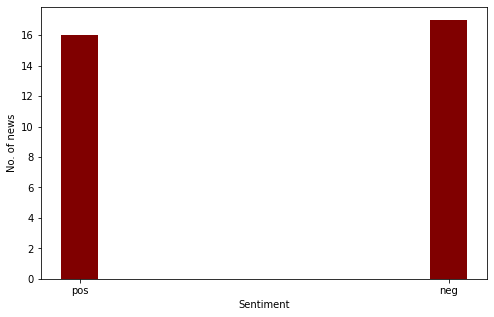

In [ ]:
sentiment = list(sentiment_result.keys())
values = list(sentiment_result.values())
  
fig = plt.figure(figsize = (8, 5))
 
# creating the bar plot
plt.bar(sentiment, values, color ='maroon',width = 0.1)
plt.xlabel("Sentiment")
plt.ylabel("No. of news")
plt.show()

In [ ]:
def percentage(part, whole):
  temp = 100 * float(part) / float(whole)
  return format(temp, '.2f')

In [ ]:
def visualization(positive, neutral, negative):
  labels = ['Positive [' + str(positive) + '%]','Neutral [' + str(neutral) + '%]',
            'Negative [' + str(negative) + '%]']
  sizes = [positive, neutral, negative]
  colors = ['lightgreen', 'gold', 'red']
  patches, texts = plt.pie(sizes, colors=colors, startangle=90)
  plt.title('Aggregate sentiment value of the financial news headlines')
  plt.legend(patches, labels, loc="best")
  plt.axis('equal')
  plt.tight_layout()
  plt.show()

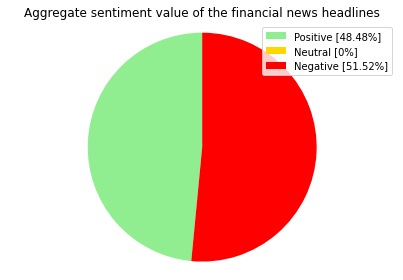

In [ ]:
all_num = sentiment_result['pos'] + sentiment_result['neg']
pos_percent = percentage(part=sentiment_result['pos'], whole=all_num)
neg_percent = percentage(part=sentiment_result['neg'], whole=all_num)

visualization(positive=pos_percent,neutral=0, negative=neg_percent)

Hence we were able to reduce the number of neutral news from the vader-lexicon model.The rnn model classifies about 81.82% of the news as positive and the rest as negative.Now we'll featch the stock data from Yahoo finance site and combine them with the news sentiment.

In [ ]:
import yfinance as yf
df_stock= yf.download("ADANIENT.NS", start="2020-01-01", end="2021-05-20",group_by="ticker")

[*********************100%***********************]  1 of 1 completed


In [ ]:
df_stock['Daily Returns']=df_stock['Close']-df_stock['Close'].shift(1)
df_stock.drop('Adj Close',axis=1,inplace=True)
df_stock.drop('Open',axis=1,inplace=True)
df_stock.drop('High',axis=1,inplace=True)
df_stock.drop('Low',axis=1,inplace=True)
df_stock.drop('Volume',axis=1,inplace=True)
df_stock.head()

,Close,Daily Returns
Date,,
2020-01-01,207.850006,NaN
2020-01-02,211.199997,3.349991
2020-01-03,208.300003,-2.899994
2020-01-06,199.550003,-8.750000
2020-01-07,204.050003,4.500000


In [ ]:
df['Date'] = pd.to_datetime(df.Date, format='%Y-%m-%d')

In [ ]:
df_combo=pd.merge(df,df_stock,how='outer',on='Date')

In [ ]:
df_combo.head()

,Time,Date,Headlines,News,Compound,Sentiment,Close,Daily Returns
0,9.00 am,2020-11-06,Adani Enterpris Standalone September 2020 Net ...,Reported Standalone quarterly numbers for Ada...,0.830681,pos,352.100006,-0.649994
1,4.22 pm,2020-11-05,Adani Enterpris Consolidated September 2020 Ne...,Reported Consolidated quarterly numbers for A...,0.510388,pos,352.750000,0.899994
2,9.04 pm,2020-11-04,"Adani Enterprises To Invest Rs 50,000 Crore On...",Adani Group's flagship firm Adani Enterprises...,0.326735,neg,351.850006,7.050018
3,6.40 pm,2020-11-04,Adani Enterprises Posts Rs 436 Crore Quarterly...,"Turning profitable in the September quarter, ...",0.555708,pos,351.850006,7.050018
4,4.41 pm,2020-08-25,Kerala HC Refuses To Stay Privatisation Of Thi...,The Kerala High Court on Tuesday declined to ...,0.233357,neg,307.549988,58.849991


In [ ]:
df_combo=df_combo.sort_values('Date')

Now , the compound score ranged from 0 to 1 on applying the rnn model.Let us convert the compound score range to -0.5 to 0.5.

In [ ]:
df_combo['Compound']=df_combo['Compound']-0.5

In [ ]:
df_combo.head()

,Time,Date,Headlines,News,Compound,Sentiment,Close,Daily Returns
33,NaN,2020-01-01,NaN,NaN,NaN,NaN,207.850006,NaN
34,NaN,2020-01-02,NaN,NaN,NaN,NaN,211.199997,3.349991
35,NaN,2020-01-03,NaN,NaN,NaN,NaN,208.300003,-2.899994
36,NaN,2020-01-06,NaN,NaN,NaN,NaN,199.550003,-8.750000
37,NaN,2020-01-07,NaN,NaN,NaN,NaN,204.050003,4.500000


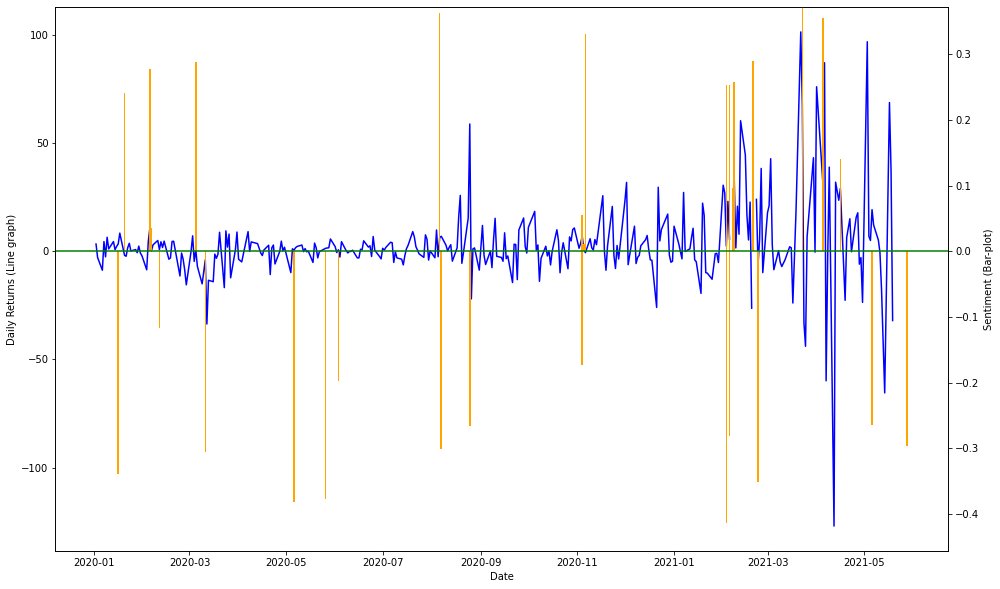

In [ ]:

fig, ax1 = plt.subplots(figsize=(16,10))
plt.plot(df_combo['Date'],df_combo['Daily Returns'],color = 'b')
ax2 = ax1.twinx()
plt.bar(df_combo['Date'], df_combo['Compound'], color ='orange',width = 1)

ax1_range = ax1.get_ylim()[1] - ax1.get_ylim()[0]
fct = (0 - ax1.get_ylim()[0])/ax1_range

ax2_ylim = ax2.get_ylim()
# calculate new values for the second axis
ax2_ylim_new = (ax2_ylim[0],(0 - ax2_ylim[0]) / fct + ax2_ylim[0])
# set new limits
ax2.set_ylim( ax2_ylim_new )

ax1.set_xlabel('Date')
ax1.set_ylabel('Daily Returns (Line graph)')
ax2.set_ylabel('Sentiment (Bar-plot)')

plt.axhline(y=0, color='g', linestyle='-')
plt.show()

We will mark those points as anomaly in which the news sentiment cannot interpret the daily returns of the stock i.e when the sentiment of the news is positive but the daily returns on the day of release of the news is negative and vice-versa.

In [ ]:
def anomaly_detection(x):
  if pd.notna(x[4]) and pd.notna(x[7]):
    if x[4]>0.0 and x[7]<0.0:
      return 1
    elif x[4]<0.0 and x[7]>0.0:
      return 1
    else:
      return 0
  else:
    return 0


In [ ]:
df_combo['Potential_anomaly'] = df_combo.apply(anomaly_detection, axis=1)

In [ ]:
df_combo.Potential_anomaly.value_counts()

0    335
1     16
Name: Potential_anomaly, dtype: int64

In [ ]:
df_combo[df_combo['Potential_anomaly']==1]

,Time,Date,Headlines,News,Compound,Sentiment,Close,Daily Returns,Potential_anomaly
18,7.56 pm,2020-01-16,"CBI Books Adani Enterprises, 3 Ex-NCCF Officia...",The CBI has booked Ahmedabad-based Adani Ente...,-0.340015,neg,220.000000,3.399994,1
17,11.30 am,2020-01-20,Adani Enterprises Denies Wrongdoing Amid Alleg...,Adani Enterprises on Monday said that it has ...,0.241128,pos,226.550003,-1.849991,1
14,9.28 pm,2020-02-11,Adani Enterprises Arm Incorporates Three Wholl...,on Tuesday said its arm AAHL has incorporate...,-0.117103,neg,245.300003,0.800003,1
11,3.01 pm,2020-05-06,Adani Enterpris Consolidated March 2020 Net Sa...,Reported Consolidated quarterly numbers for A...,-0.377619,neg,133.250000,0.550003,1
9,7.30 pm,2020-05-06,"Adani Enterprises To Raise Rs 1,000 Crore Thro...",on Wednesday said its board has given in pri...,-0.275780,neg,133.250000,0.550003,1
10,4.28 pm,2020-05-06,Adani Enterprises Q4 Net Profit Declines 64% T...,Adani Enterprises on Wednesday reported a 63....,-0.382560,neg,133.250000,0.550003,1
8,9.08 am,2020-05-26,Adani Enterpris Consolidated March 2020 Net Sa...,Reported Consolidated quarterly numbers for A...,-0.377619,neg,139.500000,1.399994,1
7,7.56 am,2020-06-03,COVID-19 Impact On Operations To Be Visible In...,Impact of COVID-19 and resultant lockdown is ...,-0.196997,neg,150.649994,0.699997,1
5,9.08 am,2020-08-07,Adani Enterpris Consolidated June 2020 Net Sal...,Reported Consolidated quarterly numbers for A...,-0.300858,neg,192.899994,6.949997,1
4,4.41 pm,2020-08-25,Kerala HC Refuses To Stay Privatisation Of Thi...,The Kerala High Court on Tuesday declined to ...,-0.266643,neg,307.549988,58.849991,1


Hence the model could detect 9 potential anomalies

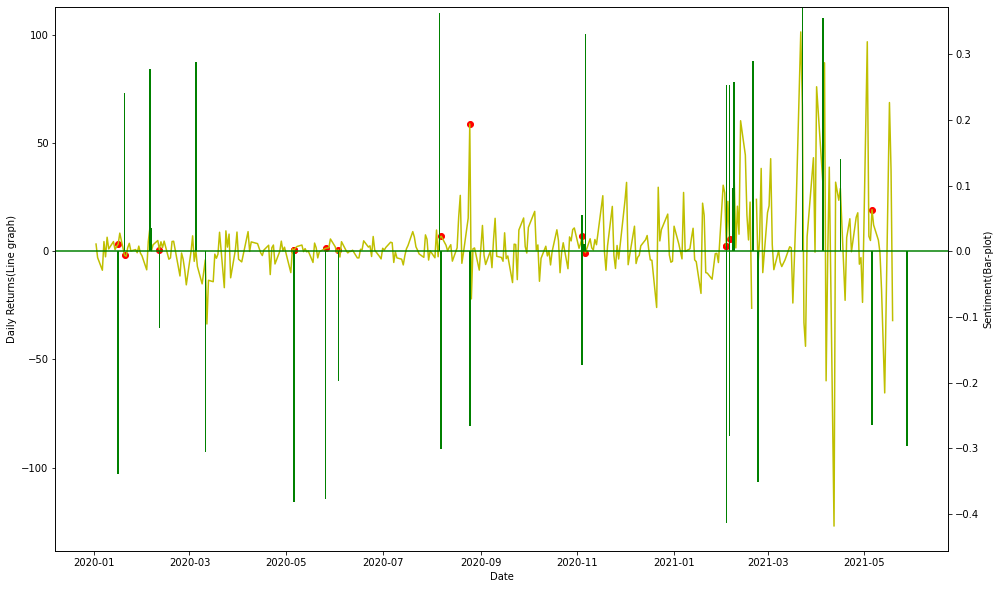

In [ ]:
fig, ax1 = plt.subplots(figsize=(16,10))
plt.plot(df_combo['Date'],df_combo['Daily Returns'],color = 'y')
plt.scatter(x=df_combo[df_combo['Potential_anomaly']==1]['Date'], y=df_combo[df_combo['Potential_anomaly']==1]['Daily Returns'], color='r')

ax2 = ax1.twinx()
plt.bar(df_combo['Date'], df_combo['Compound'], color ='green',width = 1)

ax1_range = ax1.get_ylim()[1] - ax1.get_ylim()[0]
fct = (0 - ax1.get_ylim()[0])/ax1_range

ax2_ylim = ax2.get_ylim()
# calculate new values for the second axis
ax2_ylim_new = (ax2_ylim[0],(0 - ax2_ylim[0]) / fct + ax2_ylim[0])
# set new limits
ax2.set_ylim( ax2_ylim_new )

ax1.set_xlabel('Date')
ax1.set_ylabel('Daily Returns(Line graph)')
ax2.set_ylabel('Sentiment(Bar-plot)')


#plt.scatter(x=df_combo[df_combo['Potential_anomaly']==1]['Date'], y=df_combo[df_combo['Potential_anomaly']==1]['Daily Returns'], color='r')
plt.axhline(y=0, color='g', linestyle='-')
plt.show()

Hence 16 anomaly points can be detected from this analysis.

In [ ]:
model.save('RNN_for_news_sentiment.h5')